In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix, silhouette_score, davies_bouldin_score, adjusted_rand_score
from statsmodels.distributions.empirical_distribution import ECDF

def read_data_file(filename: str) -> pd.DataFrame:
    path = Path(os.getcwd() + 'q1c.ipynb')
    data_folder = str(path.parent.absolute()) + '/data/'
    return pd.read_csv(data_folder + filename)


# top 70 % of variance filtered features
features = read_data_file('varfilter_09_freq.csv')
labels = read_data_file('Labels.csv')

features_cpy = features.copy()
df = features_cpy.join(labels['x'].copy())

cat_features = df[df.x == 0]
cat_labels = cat_features.pop('x')
cat_features.reset_index(inplace=True)

dog_features = df[df.x == 1]
dog_labels = dog_features.pop('x')
dog_features.reset_index(inplace=True)

## 1 c) ##

In [2]:
def plot_elbow(X: pd.DataFrame, k_range: range):
    sumsquares = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        sumsquares.append(kmeans.inertia_)

    plt.figure(figsize=(6,3))
    plt.plot(k_range, sumsquares, 'bo-')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Sum of squared distanses (inertia)')
    plt.title('The elbow method')
    plt.show()


def plot_overlap(X: pd.DataFrame, true_labels: pd.DataFrame, k_range: range):
    n_classes = int(true_labels.nunique())
    n_clusters = len(k_range)
    cluster_labels = {}
    fig, axes = plt.subplots(1, n_clusters, figsize=[10,5])
    bar_labels = []
    for k in k_range:
        bar_labels.append('C{}'.format(k))
    
    x = np.arange(len(bar_labels))
    width = 0.35

    zipped = zip(k_range, axes.flatten())
    for k, ax in zipped:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        cluster_labels[k] = kmeans.labels_
        C = contingency_matrix(true_labels, kmeans.labels_)
        if k < n_clusters:
            tmp = np.zeros((n_classes, n_clusters-k))
            C = np.concatenate((C,tmp), axis=1)
        rects1 = ax.bar(x - width/2, list(C[0,:]), width, label='Cats')
        rects2 = ax.bar(x + width/2, list(C[1,:]), width, label='Dogs')

        ax.set_ylabel('No. images')
        ax.set_title('Cluster class contents')

        ax.set_xticks(x, bar_labels)
        ax.legend()

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()
    return cluster_labels


def consensus_matrix(X: pd.DataFrame, k_range: range, n_subsets: int = 30) -> list:
    n = len(X.index)
    M = np.zeros((n,n))
    J = np.zeros((n,n))
    C = []

    for k in k_range:
        M = np.zeros((n, n))
        J = np.zeros((n, n))
        for m in np.arange(n_subsets):
            subX = X.sample(n=int(0.8 * n))
            kmeans = KMeans(n_clusters=k).fit(subX) 
            pred = kmeans.labels_
            for i, c1 in enumerate(pred):
                for j, c2 in enumerate(pred):
                    if c1 == c2:
                        M[subX.index[i], subX.index[j]] += 1
                    J[subX.index[i], subX.index[j]] += 1
        C.append(np.divide(M, J))
    return C


def avg_consensus_matrix(X: pd.DataFrame, k_range: range, n_subsets: int = 10, iter=10):
    n = len(X.index)
    C_sum = np.zeros((len(k_range),n,n))
    for i in range(iter):
        C = consensus_matrix(X, k_range, n_subsets)
        for k in range(len(k_range)):
            C_sum[k] += C[k]

    return C_sum / iter


def plot_eCDF_PAC(C: list, q1: int, q2: int, kmin: int, kmax: int):
    pac_scores = np.zeros(kmax-kmin)

    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle("k-means applied to CATSnDOGS dataset")
    ax1.set(title="eCDF vs. number of clusters", xlabel="Concensus matrix values", ylabel="Probability")
    for i, c in enumerate(C): 
        ecdf = ECDF(c.flatten())
        ax1.plot(ecdf.x, ecdf.y, label="k-value: %s" % str(kmin+i))
        pac_scores[i] = ecdf(q2)-ecdf(q1)

    ax1.legend(loc=4)
    ax2.set(title="PAC-score vs. number of clusters", xlabel="k-value", ylabel="PAC-score")
    ax2.plot(np.linspace(kmin, kmax-1,kmax-kmin), pac_scores, '--bo')
    fig.tight_layout()
    plt.show()


def cluster_ARI_score(X: pd.DataFrame, true_labels: pd.DataFrame, k: range) -> np.ndarray:
    cluster_scores = np.zeros(len(k_range))
    for k in k_range:
        kmeans = KMeans(n_clusters=k).fit(X)
        cluster_scores[k-1] = adjusted_rand_score(true_labels.to_numpy().ravel(), kmeans.labels_)
    return cluster_scores


def plot_ARI_score(mean: np.ndarray, std: np.ndarray):
    k_range = np.arange(1, len(mean)+1)
    plt.figure(figsize=(6,3))
    plt.plot(k_range, mean, 'o-')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('ARI')
    plt.title('Adjusted Rand Score for different k')
    plt.show()

# add std
def internal_indices(X: pd.DataFrame, k_range: range, iter: int = 10):
    silhouette = np.zeros((iter, len(k_range)))
    davies_bouldin = np.zeros_like(silhouette)
    kmin = np.min(k_range)

    for i in range(iter):
        for k in k_range:
            kmeans = KMeans(n_clusters=k).fit(X)
            silhouette[i][k-kmin] = silhouette_score(X, kmeans.labels_)
            davies_bouldin[i][k-kmin] = davies_bouldin_score(X, kmeans.labels_)
    
    silhouette_mean = np.mean(silhouette, axis=0)
    silhouette_std = np.std(silhouette, axis=0)
    davies_bouldin_mean = np.mean(davies_bouldin, axis=0)
    davies_bouldin_std = np.std(davies_bouldin, axis=0)
    return {'silhouette': (silhouette_mean, silhouette_std), 'davies_bouldin': (davies_bouldin_mean, davies_bouldin_std)}


def plot_internal_indices(indices: dict, k_range: range):
    silhouette_mean = indices['silhouette'][0]
    davies_bouldin_mean = indices['davies_bouldin'][0]
    plt.figure(figsize=(6,3))
    plt.plot(k_range, silhouette_mean, 'o-', label='Silhouette score')
    plt.plot(k_range, davies_bouldin_mean, '^-', label='Davies-Bouldin score')
    plt.xlabel('number of clusters, k')
    plt.ylabel('score')
    plt.title('Average internal indices for k-means clustering')
    plt.legend()
    plt.show()

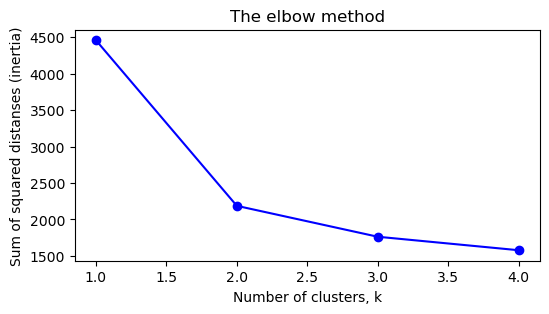

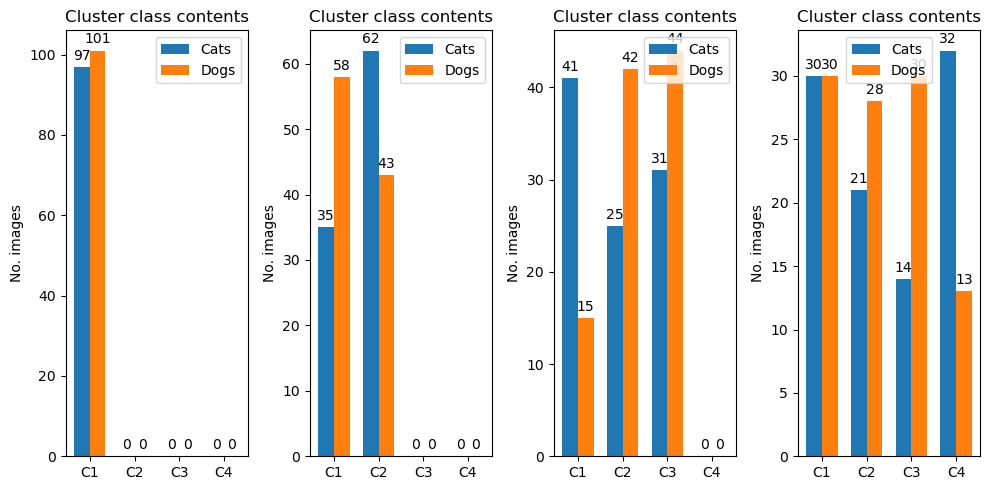

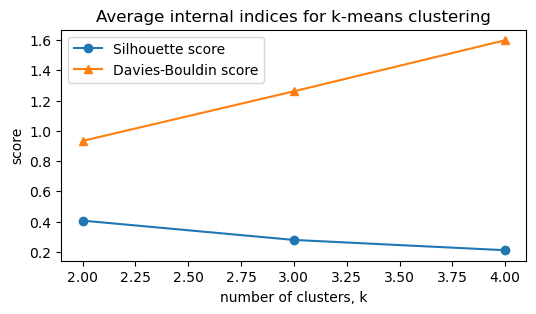

In [10]:
kmin = 1
kmax = 5
k_range = range(kmin,kmax)

plot_elbow(features, k_range)
plot_overlap(features, labels, k_range)

q1 = 0.01
q2 = 0.99
kmin_con = 2
kmax_con = 5
k_range_con = range(kmin_con,kmax_con)

indices = internal_indices(features,k_range_con, iter=10)
plot_internal_indices(indices, k_range_con)

C_avg = avg_consensus_matrix(features, k_range_con, n_subsets=30, iter=10)
plot_eCDF_PAC(C_avg, q1, q2, kmin=kmin_con, kmax=kmax_con)

## 1 d) ##

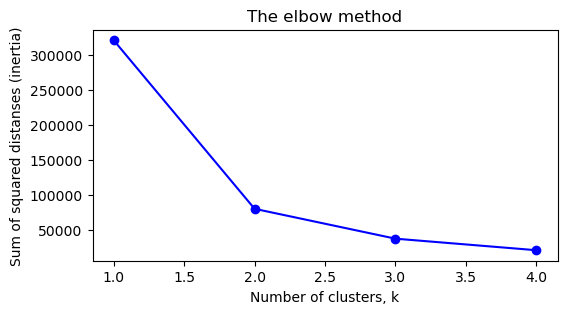

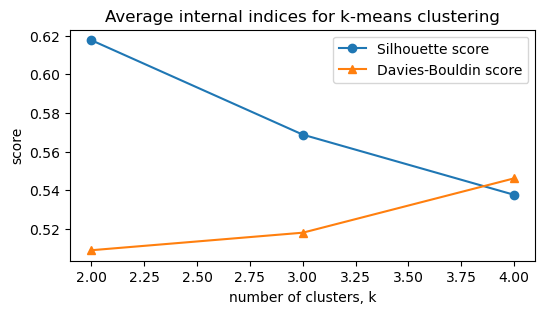

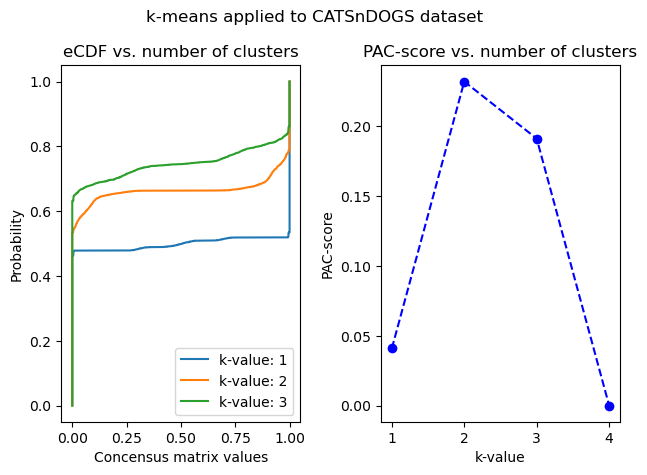

In [11]:
kmin = 1
kmax = 5
k_range = range(kmin,kmax)

plot_elbow(cat_features, k_range)

q1 = 0.01
q2 = 0.99
kmin_con = 2
kmax_con = 5
k_range_con = range(kmin_con,kmax_con)

indices = internal_indices(cat_features, k_range_con, iter=10)
plot_internal_indices(indices, k_range_con)

C_avg = avg_consensus_matrix(cat_features, k_range_con, n_subsets=30, iter=10)
plot_eCDF_PAC(C_avg, q1, q2, kmin=kmin, kmax=kmax)

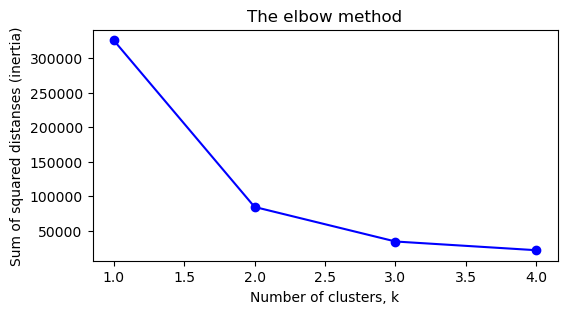

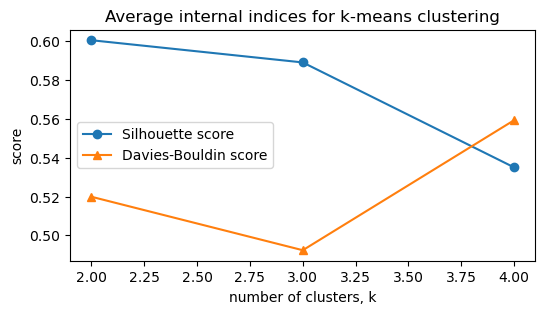

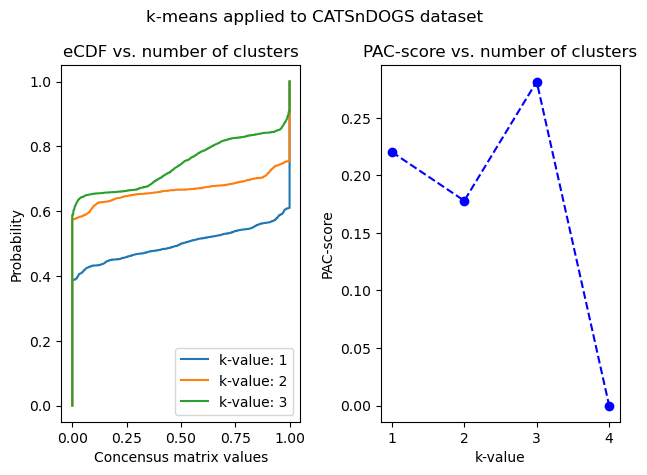

In [12]:
kmin = 1
kmax = 5
k_range = range(kmin,kmax)

plot_elbow(dog_features, k_range)

q1 = 0.01
q2 = 0.99
kmin_con = 2
kmax_con = 5
k_range_con = range(kmin_con,kmax_con)

indices = internal_indices(dog_features, k_range_con, iter=10)
plot_internal_indices(indices, k_range_con)

C_avg = avg_consensus_matrix(dog_features, k_range_con, n_subsets=30, iter=10)
plot_eCDF_PAC(C_avg, q1, q2, kmin=kmin, kmax=kmax)